A2C

In [199]:
import time
import torch
import torch.nn as nn
import gym, gym_unbalanced_disk, time
import numpy as np
import matplotlib.pyplot as plt

Discretization

In [200]:
def normalize(theta):
    return (theta+np.pi)%(2*np.pi) - np.pi # map to [-pi,pi]

class Discretize(gym.Wrapper): # only discrete action
    def __init__(self,env,num_act=7):
        super(Discretize,self).__init__(env) #sets self.env , call function from father calss
        self.num_act = num_act
        self.action_space = gym.spaces.Discrete(self.num_act)
        self.alow, self.ahigh = env.action_space.low, env.action_space.high
        # action discrete list.--no need! since we map action from index like to (-3,3)
        # self.stepsize = (self.ahigh-self.alow)/self.num_act
        # self.act_values_list = np.arange(self.alow,self.ahigh,self.stepsize)
        
    def step(self,action):
        action = self.discretize_act(action)
        obs,_,done,info = self.env.step(action)
        # velocity from (-infi,infi) to (-pi,pi)
        obs[0] = normalize(obs[0])
        reward = self.reward_fc(obs,action=action)

        return np.array(obs),reward,done,info

    def discretize_act(self,action): ##!!! action input is from 0 1 2... num-1;  output is -3,...0,...3
        # stepsize = (self.ahigh-self.alow)/self.num_act
        # values_list = np.arange(self.alow,self.ahigh,stepsize)
        # out = values_list[np.abs(values_list-action).argmin()] 
        step_size = (self.ahigh-self.alow)/(self.num_act-1)
        action = action*step_size +self.alow
        return action
    
    def reward_fc(self,obs,action):
        theta = normalize(obs[0]) # already mapped so [-pi,pi]
        omega = obs[1]
        # reward_vel = omega/40 * np.exp(-abs(theta)) # /40 to reduce -> (0,1) 
        reward_th =  np.exp(- (abs(theta)-np.pi)**2/(2*(np.pi/10)**2)) # **2 so no abs here!
       
        if abs(theta)>3 and omega<0.1 :
            if abs(action)<=1:
                reward =    2*reward_th +5*(3-abs(action)) +2 # 2*reward_vel +10
            elif abs(action)>2:
                reward =  2*reward_th - 2* abs(action)
            else:
                reward =    2*reward_th + 1*(3-abs(action)) + 2
        elif abs(theta)<1/3*np.pi and omega<0.5:
            reward =    2*reward_th + abs(action) -3  # 2*reward_vel -1 
        else:
            reward =     2*reward_th +2  # 2*reward_vel

        # alpha, beta, gamma = 100, 0.05, 0.5
        # reward = alpha*theta**2 - beta*omega**2 - gamma*action**2

        return reward

    def reset(self):
        return np.array(self.env.reset())




A2C class

In [201]:
class ActorCritic(nn.Module):
    def __init__(self, env,num_hidden_cri=40, num_hidden_act=40):
        super(ActorCritic, self).__init__()
        num_inputs = env.observation_space.shape[0] # 2 elements
        num_acts = env.action_space.n # discretized action space

        # define critic layers 
        self.cri_linear1 = nn.Linear(num_inputs,num_hidden_cri)
        self.cri_linear2 = nn.Linear(num_hidden_cri,1)

        # define actor layers
        self.act_linear1 =nn.Linear(num_inputs,num_hidden_act)
        self.act_linear2 = nn.Linear(num_hidden_act,num_acts)
        #self.softmax = nn.Softmax(dim=-1) 

    def forward(self,state): # (batch, obs)
        return self.critic(state),self.actor(state)

    def critic(self,state):
        a=torch.tanh(self.cri_linear1(state))
        out = self.cri_linear2(a)[:,0] # N*1
        return out
    
    def actor(self,state,return_logp=False):
        a = torch.tanh(self.act_linear1(state))
        a = self.act_linear2(a)
        a = a - torch.max(a,dim=1,keepdim=True)[0] # for each sample, find max value action, -max
        #p_a = self.softmax(a) # probability

        logp = a - torch.log(torch.sum(torch.exp(a),dim=1,keepdim=True)) #log of the softmax, so called log_softmax, is not log(softmax)!

        if return_logp ==False:
            return torch.exp(logp) # (num_acts,1)
        
        
        if return_logp ==True:

            return logp

        

ROLLOUT interact with env

In [202]:
def rollout(actor_crit, env, N_rollout=10_000):
    #save the following (use .append)
    Start_state = [] # holding an array of (x_t)
    Actions = []     # holding an array of (u_t)
    Rewards = []     # holding an array of (r_{t+1})
    End_state = []   # holding an array of (x_{t+1})
    Terminal = []    # holding an array of (terminal_{t+1})
    # actor as policy pi
    pi = lambda input: actor_crit.actor(torch.tensor(input[None,:],dtype=torch.float32))[0].numpy()
    with torch.no_grad():
        obs = env.reset()
        for i in range(N_rollout):
            # based on probability, randomly choose action # based actor results, sample index!?
            action = np.random.choice(a=env.action_space.n,p=pi(obs)) #b=) env.act_values_list

            Start_state.append(obs)
            Actions.append(action)

            obs_next, reward, done, info = env.step(action)

            terminal = done and not info.get('TimeLimit.truncated', False)

            Terminal.append(terminal)
            Rewards.append(reward)
            End_state.append(obs_next)

            if done:
                obs = env.reset()
            else:
                obs = obs_next

    #error checking:
    assert len(Start_state)==len(Actions)==len(Rewards)==len(End_state)==len(Terminal), f'error in lengths: {len(Start_state)}=={len(Actions)}=={len(Rewards)}=={len(End_state)}=={len(Terminal)}'
    return np.array(Start_state), np.array(Actions), np.array(Rewards), np.array(End_state), np.array(Terminal).astype(int)


Train

In [203]:
def eval_actor(actor_critic, env):
    pi = lambda x: actor_critic.actor(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy()
    with torch.no_grad():
        rewards_acc = 0
        obs = env.reset()
        while True:
            action = np.argmax(pi(obs)) #b=)
            obs, reward, done, info = env.step(action)
            rewards_acc += reward
            if done:
                return rewards_acc

In [204]:
def A2C_train(actor_critic, optimizer, env, N_iter=21,N_rollout=20000,N_epochs=10, batch_size=32,N_evals=10,\
              alpha_actor=0.5,alpha_entropy=0.5,gamma=0.98):
    best = -float('inf')
    #torch.save(actor_critic.state_dict(),'A2C-Best.pth')

    try:
        for iteration in range(N_iter):
            print(f'Rollout iteration {iteration+1}')
            # rollout to get trajectory record
            Start_state, Actions, Rewards, End_state, Terminal = rollout(actor_critic, env, N_rollout=N_rollout)
            # data 
            Start_state = torch.tensor(Start_state,dtype=torch.float32)
            Rewards = torch.tensor(Rewards,dtype=torch.float32)
            End_state =torch.tensor(End_state,dtype=torch.float32)
            Terminal = torch.tensor(Terminal,dtype=torch.float32)
            Actions = Actions.astype(int)

            print('Starting training on rollout information...')
            for epoch in range(N_epochs):
                for i in range(batch_size,len(Start_state)+1,batch_size):
                    Start_state_batch, Actions_batch, Rewards_batch, End_state_batch, Terminal_batch = \
                    [d[i-batch_size:i] for d in [Start_state, Actions, Rewards, End_state, Terminal]]

                    #Advantage:
                    Vnow = actor_critic.critic(Start_state_batch) 
                    Vnext = actor_critic.critic(End_state_batch) 
                    A = Rewards_batch + gamma*Vnext*(1-Terminal_batch) - Vnow 

                    # convert from action to index.  # Now action is 0 1 2.. index value，convert in step function=>（-3，3）
                    ##### 
                    
                    action_index = np.stack((np.arange(batch_size),Actions_batch),axis=0)
                    logp = actor_critic.actor(Start_state_batch,return_logp=True)# return is 【N——batch，num_action】 
                    logp_cur = logp[action_index] # do slice，dim0 batch，dim1 use action value ，to get probability
                    p = torch.exp(logp) 

                    L_value_function = torch.mean(A**2) 
                    L_policy = -(A.detach()*logp_cur).mean() #detach A, the gradient should only to through logp
                    L_entropy = -torch.mean((-p*logp),0).sum() 

                    Loss = L_value_function + alpha_actor*L_policy + alpha_entropy*L_entropy 

                    optimizer.zero_grad()
                    Loss.backward()
                    optimizer.step()
                
                print(f'logp{p[0]} logp{logp.shape}')

                score = np.mean([eval_actor(actor_critic, env) for i in range(N_evals)])
                
                print(f'iteration={iteration+1} epoch={epoch+1} Average Reward per episode:',score)
                print(f'\t Value loss:  {L_value_function.item(): .4f}')
                print(f'\t Policy loss: {L_policy.item(): .4f}')
                print(f'\t Entropy:     {-L_entropy.item(): .4f}')

                if score>best:
                    best = score
                    print(f'################################# \n new best {best: .4f} saving actor-crit... \n#################################')
                    torch.save(actor_critic.state_dict(),'A2C-Best.pth')
            print('loading best result')
            actor_critic.load_state_dict(torch.load('A2C-Best.pth'))
    finally: # this will always run even when using the a KeyBoard Interrupt.
        print('loading best result')
        actor_critic.load_state_dict(torch.load('A2C-Best.pth'))


            

In [205]:
def show(actor_critic,env):
    pi = lambda x: actor_critic.actor(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy()
    with torch.no_grad():
        try:
            obs = env.reset()
            env.render()
            time.sleep(1)
            while True:
                action = np.argmax(pi(obs)) 
                obs, reward, done, info = env.step(action)
                print(obs, reward, done, info)
                time.sleep(1/60)
                env.render()
                if done:
                    time.sleep(0.5)
                    break
        finally: #this will always run even when an error occurs
            env.close()

RUN it 

Rollout iteration 1
Starting training on rollout information...
logptensor([2.4622e-01, 1.6910e-01, 1.9184e-02, 1.5379e-03, 1.5028e-04, 5.1533e-04,
        3.6081e-04, 3.3580e-04, 1.2432e-01, 1.3058e-01, 3.0770e-01],
       grad_fn=<SelectBackward0>) logptorch.Size([32, 11])
iteration=1 epoch=1 Average Reward per episode: 40.00000000007157
	 Value loss:   2.8956
	 Policy loss: -4.7647
	 Entropy:      1.7107
################################# 
 new best  40.0000 saving actor-crit... 
#################################
logptensor([3.8603e-01, 1.1213e-01, 2.4504e-09, 7.0497e-11, 1.9847e-13, 6.6202e-12,
        1.7860e-12, 1.1729e-12, 1.9670e-05, 2.7581e-04, 5.0154e-01],
       grad_fn=<SelectBackward0>) logptorch.Size([32, 11])
iteration=1 epoch=2 Average Reward per episode: 1965.0033367696983
	 Value loss:   1.9375
	 Policy loss: -16.0626
	 Entropy:      1.3302
################################# 
 new best  1965.0033 saving actor-crit... 
#################################
logptensor([4.3668

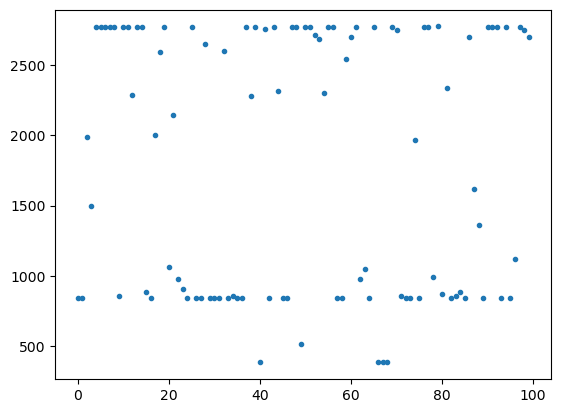

[0.02181725 1.90248623] 2.0 False {}
[0.0807325 2.7741735] 2.0 False {}
[0.14972908 2.5794117 ] 2.0 False {}
[0.22029066 3.01347671] 2.0 False {}
[0.28840246 2.38124783] 2.0 False {}
[0.34812957 2.40856513] 2.0 False {}
[0.40699558 2.26042347] 2.0 False {}
[0.45919049 1.95001773] 2.0000000000000004 False {}
[0.50972903 1.92584753] 2.0000000000000013 False {}
[ 0.51521113 -1.34113361] -0.5999999999999988 False {}
[ 0.43849208 -4.69311227] 0.0 False {}
[ 0.28440428 -7.59789813] 0.0 False {}
[ 0.06468414 -9.83652142] 0.0 False {}
[ -0.19951392 -11.23057929] 0.0 False {}
[ -0.49120497 -11.72405068] 8.881784197001252e-16 False {}
[ -0.78083193 -11.3923635 ] 1.0942358130705543e-12 False {}
[ -1.0538869  -10.44038555] 2.000000000514745 False {}
[-1.29906199 -9.10781908] 2.00000006786709 False {}
[-1.50716246 -7.61953219] 2.0000026521735492 False {}
[-1.62941913 -1.98683672] 2.000018620411578 False {}
[-1.61153515  3.24182415] 2.000014134637033 False {}
[-1.49675183  5.73206129] 2.000002230950

In [206]:

max_episode_steps = 1000 

env = gym.make('unbalanced-disk-v0', dt=0.025, umax=3.)
env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps) #c)
env = Discretize(env, num_act=11)

# Define training (Hyper)-parameters
gamma = 0.99
batch_size = 32 
N_iterations = 10
N_rollout = 2000#0
N_epochs = 5
N_evals = 10
alpha_actor = 0.5
alpha_entropy = 0.6
lr = 5e-3


assert isinstance(env.action_space,gym.spaces.Discrete), 'action space requires to be discrete'

actor_crit = ActorCritic(env, num_hidden_act=40,num_hidden_cri=40)
optimizer = torch.optim.Adam(actor_crit.parameters(), lr=lr) #low learning rate

A2C_train(actor_crit, optimizer, env, N_iter=N_iterations,N_rollout=N_rollout,N_epochs=N_epochs, batch_size=batch_size ,N_evals=N_evals,\
              alpha_actor=alpha_actor,alpha_entropy=alpha_entropy,gamma=gamma)

plt.plot([eval_actor(actor_crit, env) for i in range(100)],'.')
plt.show()
show(actor_crit,env)


In [209]:
show(actor_crit,env)

[0.02286364 1.90355445] 2.0 False {}
[0.08227019 2.77543255] 2.0 False {}
[0.15037921 2.58431806] 2.0 False {}
[0.21868914 3.01627959] 2.0 False {}
[0.28673583 2.38731575] 2.0 False {}
[0.34874661 2.4155977 ] 2.0 False {}
[0.40689953 2.26583864] 2.0 False {}
[0.46187888 1.95553165] 2.0000000000000004 False {}
[0.50910272 1.93078932] 2.0000000000000013 False {}
[ 0.51595258 -1.33767344] -0.5999999999999988 False {}
[ 0.44026213 -4.69151795] 0.0 False {}
[ 0.28397341 -7.59736652] 0.0 False {}
[ 0.06299977 -9.83741947] 0.0 False {}
[ -0.20059255 -11.23533493] 0.0 False {}
[ -0.49041686 -11.72897455] 8.881784197001252e-16 False {}
[ -0.77934796 -11.39888291] 1.056044141023449e-12 False {}
[ -1.05493287 -10.44396841] 2.000000000526258 False {}
[-1.29839036 -9.11287452] 2.0000000670212974 False {}
[-1.50743141 -7.62525714] 2.0000026640110833 False {}
[-1.62736156 -1.99171634] 2.0000180421719884 False {}
[-1.61272226  3.23728395] 2.0000143970688247 False {}
[-1.5010018   5.72709746] 2.0000023